In [1]:
import pandas as pd
import numpy as np
import nltk
import nltk.sentiment.util
import matplotlib.pyplot as plt
import pprint
import re
import gensim
import gensim.corpora as corpora
import os
import pandas as pd
import numpy as np
import nltk
import nltk.sentiment.util
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import pprint
import re
import gensim
import gensim.corpora as corpora
import os
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import string
import math
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [2]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [3]:
df = pd.read_csv('../../amazon_reviews_us_Grocery_v1_00_sentiment.csv').sample(50000)

df = df.drop(["marketplace", "customer_id", "product_parent", "product_category", "review_date"], axis=1)

df = df[~df['review_body'].isnull()]

df['review_body'] = df['review_headline'] + '. ' + df['review_body']

df["health_hazard"] = np.nan

df = df.set_index("review_id")

In [4]:
neg_reviews = df.query("star_rating < 4", engine="python")

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['br'])
translator=str.maketrans('','',string.punctuation)

neg_reviews["tokened_review"] = np.nan
for index, row in neg_reviews.iterrows():
    text = row["review_body"].lower()
    text = text.translate(translator)
    text = word_tokenize(text)
    new_text = []
    for token in text:
        token = stemmer.stem(token)
        if token not in stop_words:
            new_text.append(token)
    neg_reviews.loc[index, "tokened_review"] = ' '.join(new_text)
neg_reviews["tokened_review"][0]

<ipython-input-5-5557a774945a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_reviews["tokened_review"] = np.nan
C:\Users\MattW\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


'problem sand bought 25 lb thi hull millet back aug lot 1250421583 lowest price could find arriv time problem began show first bottom bag wa sewn without first fold grain leak stitch secondli quartzlik sand 1 mm size millet made loud crunch bit wa audibl across dinner tabl encount thi sand rate 7 per bowl millet consum 4 lb decid dispos remain millet cost millet noth compar cost fix broken tooth buy bob red mill millet befor expens run thi problem'

In [6]:
hazardous_words=["rotten", "mouldy", "moldy", "mold", "mould", "sick", "dangerous", "diarrhea", "poisoning", "stale", "contaminate",'disease', 'disgusting', 'hospital', 'poisoning', 'hazardous', 'ill', 'mold','moldy', 'mildew', 'dangerous' 'rancid', 'smelly', 'stale', 'unhealthy', 'sick','expired','expiration']
for word in hazardous_words:
    neg_reviews.loc[[word in tokened_review for tokened_review in neg_reviews["tokened_review"]], "health_hazard"] = 1
    

In [7]:
num_labeled = len(neg_reviews.query("health_hazard == 1", engine="python"))
num_labeled

456

In [8]:
non_hazardous = neg_reviews.query("health_hazard != 1 and polarity < 0", engine="python").sample(num_labeled)
for i in list(non_hazardous.index):
    neg_reviews.loc[i, "health_hazard"] = 0

C:\Users\MattW\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [9]:
labeled = neg_reviews.query("health_hazard == 0 or health_hazard == 1", engine="python")
reviews = labeled.loc[:, 'tokened_review'].values
y = labeled.loc[:, 'health_hazard'].values

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
matrix = TfidfVectorizer(max_features=200)
X = matrix.fit_transform(reviews).toarray()
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.30723521,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.29841081,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.18382904,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
#from sklearn.naive_bayes import GaussianNB
#classifier = GaussianNB()

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(X_train, y_train)

# Predict Class
y_pred = classifier.predict(X_test)

# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8903508771929824


In [13]:
trial = neg_reviews.sample(100)

In [14]:
matrix.get_feature_names()

['actual',
 'ad',
 'almost',
 'also',
 'amazon',
 'ani',
 'anoth',
 'anyth',
 'arriv',
 'aw',
 'away',
 'back',
 'bad',
 'bag',
 'bar',
 'bean',
 'becaus',
 'befor',
 'better',
 'big',
 'bit',
 'bitter',
 'bottl',
 'bought',
 'box',
 'brand',
 'buy',
 'came',
 'candi',
 'cant',
 'care',
 'case',
 'chip',
 'chocol',
 'coconut',
 'coffe',
 'color',
 'come',
 'compani',
 'contain',
 'cooki',
 'corn',
 'could',
 'cup',
 'date',
 'day',
 'didnt',
 'differ',
 'disappoint',
 'doe',
 'doesnt',
 'dont',
 'dri',
 'drink',
 'eat',
 'end',
 'enough',
 'even',
 'ever',
 'expect',
 'expens',
 'expir',
 'feel',
 'find',
 'first',
 'flavor',
 'food',
 'found',
 'free',
 'fresh',
 'get',
 'gift',
 'give',
 'go',
 'good',
 'got',
 'great',
 'green',
 'ha',
 'half',
 'hard',
 'high',
 'hope',
 'horribl',
 'howev',
 'ill',
 'im',
 'ingredi',
 'item',
 'ive',
 'know',
 'last',
 'leav',
 'like',
 'littl',
 'local',
 'look',
 'lot',
 'love',
 'made',
 'make',
 'mani',
 'mayb',
 'mix',
 'mold',
 'moldi',
 'mo

In [15]:
trial = neg_reviews
trial_x = trial.loc[:,"tokened_review"].values
trial_X = matrix.fit_transform(trial_x).toarray()
trial_y = classifier.predict(trial_X)
trial_y

array([1., 0., 0., ..., 0., 0., 0.])

In [16]:
neg_reviews["health_hazard"] = trial_y

<ipython-input-16-56d181f868ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_reviews["health_hazard"] = trial_y


In [17]:
dangerous = neg_reviews.query("health_hazard == 1", engine="python")
dangerous

product_id                                      product_title  \
review_id                                                                       
R25HF39YGX4OOH  B0049YP724  Great River Organic Milling, Organic Whole Gra...   
RPOE2G71QXVDN   B002HQNCBO                          J&D Baconnaise Mayonnaise   
R1EHDKKMS466DF  B0000E6NM9                         Get Well Care Package Gift   
R3TA1QC4I2MZFM  B0009XBQE2                    Li Hing Mui Powder (2 Packages)   
R28OP30SRLAN3V  B003ZIR8YU  Kirkland Signature European Cookies with Belgi...   
...                    ...                                                ...   
R2H2ZD8VL97J9E  B000LLMALU          Mezzetta Pickled Spicy Garlic (Pack of 6)   
RJCJRM0FXE3S4   B0078EJEBW         Elite Black Angus Boneless Prime Rib Roast   
R25KB8OOAW9HZP  B0001M0Z4S  Frontier Co-op Maple Flavor, Non-Alcoholic, 2 ...   
R3RGXH1LJRYRJ   B009M516HA  Side Mates Couscous, Three-Cheese, 5.9 Ounce (...   
R2KH2EMOEJNAZ1  B007GR6PL8  Cambridge & Thames Mixed Fruit Drops (5.3 oz Can)   

                star_rating  helpful_votes  total_votes vine  \
review_id                                                      
R25HF39YGX4OOH            2              4            5    N   
RPOE2G71QXVDN             2              0            0    N   
R1EHDKKMS466DF            1             26           30    N   
R3TA1QC4I2MZFM            2              0            1    N   
R28OP30SRLAN3V            1              1            1    N   
...                     ...            ...          ...  ...   
R2H2ZD8VL97J9E            2              1            1    N   
RJCJRM0FXE3S4             3              5            6    N   
R25KB8OOAW9HZP            1              0            1    N   
R3RGXH1LJRYRJ             3              0            0    Y   
R2KH2EMOEJNAZ1            2              2            2    N   

               verified_purchase  \
review_id                          
R25HF39YGX4OOH                 Y   
RPOE2G71QXVDN                  N   
R1EHDKKMS466DF                 Y   
R3TA1QC4I2MZFM                 Y   
R28OP30SRLAN3V                 Y   
...                          ...   
R2H2ZD8VL97J9E                 Y   
RJCJRM0FXE3S4                  Y   
R25KB8OOAW9HZP                 N   
R3RGXH1LJRYRJ                  N   
R2KH2EMOEJNAZ1                 Y   

                                                  review_headline  \
review_id                                                           
R25HF39YGX4OOH                                  Problem with sand   
RPOE2G71QXVDN              It is a good idea but a poor execution   
R1EHDKKMS466DF                                     Total rip-off!   
R3TA1QC4I2MZFM  I should have read the ingredients before purc...   
R28OP30SRLAN3V                                           One Star   
...                                                           ...   
R2H2ZD8VL97J9E                                              Mushy   
RJCJRM0FXE3S4                                Not what we expected   
R25KB8OOAW9HZP  Does Not Taste Or Smell Like Maple, No Real Ma...   
R3RGXH1LJRYRJ                                           Easy side   
R2KH2EMOEJNAZ1                                      Disappointing   

                                                      review_body  polarity  \
review_id                                                                     
R25HF39YGX4OOH  Problem with sand. Bought 25 lb. of this hulle... -0.008333   
RPOE2G71QXVDN   It is a good idea but a poor execution. I shou...  0.201101   
R1EHDKKMS466DF  Total rip-off!. I ordered this for a custodian...  0.079697   
R3TA1QC4I2MZFM  I should have read the ingredients before purc...  0.175000   
R28OP30SRLAN3V  One Star. I ordered these hoping they would be...  0.150000   
...                                                           ...       ...   
R2H2ZD8VL97J9E  Mushy. Two stars, two complaints.<br /><br />F... -0.063889   
RJCJRM0FXE3S4   Not what we expected. We ordered th

In [18]:
#data['review_body'] = data['review_body'].map(lambda x: re.sub('[,\.!?]', '', x))
#data['review_body'] = data['review_body'].map(lambda x: x.lower())
data = dangerous["review_body"]
data

review_id
R25HF39YGX4OOH    Problem with sand. Bought 25 lb. of this hulle...
RPOE2G71QXVDN     It is a good idea but a poor execution. I shou...
R1EHDKKMS466DF    Total rip-off!. I ordered this for a custodian...
R3TA1QC4I2MZFM    I should have read the ingredients before purc...
R28OP30SRLAN3V    One Star. I ordered these hoping they would be...
                                        ...                        
R2H2ZD8VL97J9E    Mushy. Two stars, two complaints.<br /><br />F...
RJCJRM0FXE3S4     Not what we expected. We ordered thinking we w...
R25KB8OOAW9HZP    Does Not Taste Or Smell Like Maple, No Real Ma...
R3RGXH1LJRYRJ     Easy side. This couscous side dish is easy to ...
R2KH2EMOEJNAZ1    Disappointing. Love flavored hard candies and ...
Name: review_body, Length: 2117, dtype: object

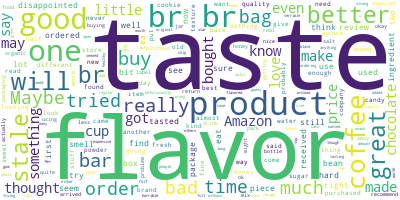

In [19]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(data.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [20]:
stop_words = stopwords.words('english')
stop_words.extend(['br','[', ',', '\\', '.', '!', '?', ']', '<', '>', '$', '£', '/', '*', '(', ')', '%', '^', '&', '-', '_', '=', '+', '|', '#','~',';',':','...',"''",'//','\\\\',"n't","'ve","'m","'s"])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(nltk.word_tokenize(str(sentence)))
        
def remove_stopwords(texts):
    return [[(te,ta) for (te,ta) in doc if (te.replace("_NEG","") not in stop_words)] for doc in texts]

data_filtered = data
data_words = list(sent_to_words(data_filtered))
# remove stop words
#data_words = remove_stopwords(data_words)
pprint.pprint(data_words[:5])
#np.array(data_words[0], dtype=object).shape

[['Problem',
  'with',
  'sand',
  '.',
  'Bought',
  '25',
  'lb',
  '.',
  'of',
  'this',
  'hulled',
  'millet',
  'back',
  'in',
  'Aug.',
  '(',
  'lot',
  '#',
  '1250421583',
  ')',
  '.',
  'It',
  "'s",
  'the',
  'lowest',
  'price',
  'that',
  'I',
  'could',
  'find',
  'and',
  'it',
  'arrived',
  'on',
  'time',
  '.',
  'Then',
  'problems',
  'began',
  'to',
  'show',
  'up',
  '.',
  'First',
  ',',
  'the',
  'bottom',
  'of',
  'the',
  'bag',
  'was',
  'sewn',
  'up',
  'WITHOUT',
  'it',
  'being',
  'first',
  'folded',
  'up',
  ',',
  'so',
  'the',
  'grains',
  'were',
  'leaking',
  'out',
  'between',
  'the',
  'stitches',
  '.',
  'Secondly',
  ',',
  'there',
  'were',
  'quartz-like',
  'sand',
  '(',
  'about',
  '1',
  'mm',
  'in',
  'size',
  ')',
  'in',
  'the',
  'millet',
  'that',
  'made',
  'a',
  'loud',
  'crunch',
  'when',
  'you',
  'bit',
  'into',
  'it',
  '.',
  'It',
  'was',
  'audible',
  'across',
  'the',
  'dinner',
  'tab

In [21]:
data_words = [[word.lower() for word in data_point] for data_point in data_words]
data_words

[['problem',
  'with',
  'sand',
  '.',
  'bought',
  '25',
  'lb',
  '.',
  'of',
  'this',
  'hulled',
  'millet',
  'back',
  'in',
  'aug.',
  '(',
  'lot',
  '#',
  '1250421583',
  ')',
  '.',
  'it',
  "'s",
  'the',
  'lowest',
  'price',
  'that',
  'i',
  'could',
  'find',
  'and',
  'it',
  'arrived',
  'on',
  'time',
  '.',
  'then',
  'problems',
  'began',
  'to',
  'show',
  'up',
  '.',
  'first',
  ',',
  'the',
  'bottom',
  'of',
  'the',
  'bag',
  'was',
  'sewn',
  'up',
  'without',
  'it',
  'being',
  'first',
  'folded',
  'up',
  ',',
  'so',
  'the',
  'grains',
  'were',
  'leaking',
  'out',
  'between',
  'the',
  'stitches',
  '.',
  'secondly',
  ',',
  'there',
  'were',
  'quartz-like',
  'sand',
  '(',
  'about',
  '1',
  'mm',
  'in',
  'size',
  ')',
  'in',
  'the',
  'millet',
  'that',
  'made',
  'a',
  'loud',
  'crunch',
  'when',
  'you',
  'bit',
  'into',
  'it',
  '.',
  'it',
  'was',
  'audible',
  'across',
  'the',
  'dinner',
  'tab

In [22]:
import nltk.sentiment.util
tokens = list(map(nltk.word_tokenize, data))
negated_tokens = list(map(nltk.sentiment.util.mark_negation, tokens))
data = negated_tokens

In [23]:
#print(data_words)
def tag(texts):
    #tokens = list(map(nltk.word_tokenize, texts))
    tagged = [nltk.pos_tag(text, tagset='universal') for text in texts]
    negated_tokens = list(map(nltk.sentiment.util.mark_negation, texts))
    negated_tagged = [[(negated_tokens[i][j], tagged[i][j][1]) for j in range(len(texts[i]))] for i in range(len(texts))]
    return negated_tagged
negated_tagged = tag(data_words)
negated_tagged

[[('problem', 'NOUN'),
  ('with', 'ADP'),
  ('sand', 'NOUN'),
  ('.', '.'),
  ('bought', 'VERB'),
  ('25', 'NUM'),
  ('lb', 'NOUN'),
  ('.', '.'),
  ('of', 'ADP'),
  ('this', 'DET'),
  ('hulled', 'VERB'),
  ('millet', 'NOUN'),
  ('back', 'ADV'),
  ('in', 'ADP'),
  ('aug.', 'NOUN'),
  ('(', '.'),
  ('lot', 'NOUN'),
  ('#', '.'),
  ('1250421583', 'NUM'),
  (')', '.'),
  ('.', '.'),
  ('it', 'PRON'),
  ("'s", 'VERB'),
  ('the', 'DET'),
  ('lowest', 'ADJ'),
  ('price', 'NOUN'),
  ('that', 'ADP'),
  ('i', 'NOUN'),
  ('could', 'VERB'),
  ('find', 'VERB'),
  ('and', 'CONJ'),
  ('it', 'PRON'),
  ('arrived', 'VERB'),
  ('on', 'ADP'),
  ('time', 'NOUN'),
  ('.', '.'),
  ('then', 'ADV'),
  ('problems', 'NOUN'),
  ('began', 'VERB'),
  ('to', 'PRT'),
  ('show', 'VERB'),
  ('up', 'PRT'),
  ('.', '.'),
  ('first', 'ADV'),
  (',', '.'),
  ('the', 'DET'),
  ('bottom', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('bag', 'NOUN'),
  ('was', 'VERB'),
  ('sewn', 'VERB'),
  ('up', 'PRT'),
  ('without', 'AD

In [49]:
data_words = remove_stopwords(negated_tagged)
data_words

C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('problem', 'NOUN'),
  ('sand', 'NOUN'),
  ('bought', 'VERB'),
  ('25', 'NUM'),
  ('lb', 'NOUN'),
  ('hulled', 'VERB'),
  ('millet', 'NOUN'),
  ('back', 'ADV'),
  ('aug.', 'NOUN'),
  ('lot', 'NOUN'),
  ('1250421583', 'NUM'),
  ('lowest', 'ADJ'),
  ('price', 'NOUN'),
  ('could', 'VERB'),
  ('find', 'VERB'),
  ('arrived', 'VERB'),
  ('time', 'NOUN'),
  ('problems', 'NOUN'),
  ('began', 'VERB'),
  ('show', 'VERB'),
  ('first', 'ADV'),
  ('bottom', 'NOUN'),
  ('bag', 'NOUN'),
  ('sewn', 'VERB'),
  ('without', 'ADP'),
  ('first', 'ADV'),
  ('folded', 'VERB'),
  ('grains', 'NOUN'),
  ('leaking', 'VERB'),
  ('stitches', 'NOUN'),
  ('secondly', 'ADV'),
  ('quartz-like', 'ADJ'),
  ('sand', 'NOUN'),
  ('1', 'NUM'),
  ('mm', 'NOUN'),
  ('size', 'NOUN'),
  ('millet', 'NOUN'),
  ('made', 'VERB'),
  ('loud', 'ADJ'),
  ('crunch', 'NOUN'),
  ('bit', 'VERB'),
  ('audible', 'ADJ'),
  ('across', 'ADP'),
  ('dinner', 'NOUN'),
  ('table', 'NOUN'),
  ('encountered', 'VERB'),
  ('sand', 'NOUN'),
  ('rate',

In [50]:
#gets adjectives

def get_adjectives(tagged):
    review_a = [word for (word, tag) in tagged if (tag == 'NOUN')]# or tag == 'ADJ')]# or tag == 'ADV' or tag == 'VERB')]
    return review_a

data_words = list(map(lambda x: get_adjectives(x), data_words))

'''
for i in range(len(data_words)):
    data_words[i] = [word for (word,tag) in data_words[i]]
'''
data_words


C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['problem',
  'sand',
  'lb',
  'millet',
  'aug.',
  'lot',
  'price',
  'time',
  'problems',
  'bottom',
  'bag',
  'grains',
  'stitches',
  'sand',
  'mm',
  'size',
  'millet',
  'crunch',
  'dinner',
  'table',
  'sand',
  'rate',
  'bowl',
  'millet',
  'lb',
  'millet',
  'cost',
  'millet',
  'nothing',
  'cost_NEG',
  'tooth_NEG',
  'bob',
  'mill',
  'millet',
  'problem_NEG'],
 ['idea',
  'execution',
  'label',
  'mayonnaise',
  'grocery',
  'store',
  'shelf',
  'bacon',
  'mayonnaise',
  'perfection',
  'problem',
  'bacon_NEG',
  'product_NEG',
  'label_NEG',
  'spread_NEG',
  'vegetarians_NEG',
  'flavor',
  'kind',
  'smell',
  'bacon',
  'treats',
  'hounds',
  'smell',
  'hands',
  'association._NEG',
  'mayonnaise_NEG',
  'thick_NEG',
  'egg',
  'yolks',
  'oil',
  'lemon',
  'juice',
  'pepper',
  'liquid',
  'smoke',
  'flavor',
  'bacon_NEG',
  'product_NEG',
  'thing',
  'product',
  'market',
  'asin',
  'b003zwv5z4',
  'bacon',
  'jam',
  'bucks',
  'ounce'

In [51]:
pprint.pprint(data[4])

['One',
 'Star',
 '.',
 'I',
 'ordered',
 'these',
 'hoping',
 'they',
 'would',
 'be',
 'great',
 '.',
 'But',
 ',',
 'they',
 'were',
 'quite',
 'stale',
 '.']


C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
pprint.pprint(corpus[:5])

C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 6),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(17, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 3),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1)],
 [(73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 

In [53]:
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       minimum_probability=0.1,
                                       workers=3,
                                       passes=2)
# Print the Keyword in the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.015*"product" + 0.011*"flavor" + 0.010*"tea" + 0.009*"time" + '
  '0.008*"coffee" + 0.007*"order" + 0.007*"taste" + 0.006*"nothing" + '
  '0.005*"bar" + 0.005*"box"'),
 (1,
  '0.016*"taste" + 0.009*"taste_NEG" + 0.009*"flavor" + 0.008*"something" + '
  '0.006*"product" + 0.006*"store" + 0.005*"chocolate" + 0.005*"water" + '
  '0.005*"coffee" + 0.005*"stale"'),
 (2,
  '0.018*"product" + 0.017*"taste" + 0.013*"flavor" + 0.012*"bars" + '
  '0.012*"coffee" + 0.007*"product_NEG" + 0.007*"chocolate" + '
  '0.005*"flavor_NEG" + 0.005*"stale" + 0.005*"bar"'),
 (3,
  '0.011*"product" + 0.010*"time" + 0.009*"price" + 0.007*"nothing" + '
  '0.007*"candy" + 0.007*"taste" + 0.006*"flavor" + 0.006*"coffee" + '
  '0.005*"something" + 0.005*"flavor_NEG"'),
 (4,
  '0.014*"flavor" + 0.010*"taste" + 0.009*"beans" + 0.008*"coffee" + '
  '0.007*"quality" + 0.007*"product" + 0.006*"chocolate" + 0.006*"box" + '
  '0.005*"bag" + 0.005*"something"')]


In [54]:
pprint.pprint(lda_model.print_topics(num_topics=100))

[(0,
  '0.015*"product" + 0.011*"flavor" + 0.010*"tea" + 0.009*"time" + '
  '0.008*"coffee" + 0.007*"order" + 0.007*"taste" + 0.006*"nothing" + '
  '0.005*"bar" + 0.005*"box"'),
 (1,
  '0.016*"taste" + 0.009*"taste_NEG" + 0.009*"flavor" + 0.008*"something" + '
  '0.006*"product" + 0.006*"store" + 0.005*"chocolate" + 0.005*"water" + '
  '0.005*"coffee" + 0.005*"stale"'),
 (2,
  '0.018*"product" + 0.017*"taste" + 0.013*"flavor" + 0.012*"bars" + '
  '0.012*"coffee" + 0.007*"product_NEG" + 0.007*"chocolate" + '
  '0.005*"flavor_NEG" + 0.005*"stale" + 0.005*"bar"'),
 (3,
  '0.011*"product" + 0.010*"time" + 0.009*"price" + 0.007*"nothing" + '
  '0.007*"candy" + 0.007*"taste" + 0.006*"flavor" + 0.006*"coffee" + '
  '0.005*"something" + 0.005*"flavor_NEG"'),
 (4,
  '0.014*"flavor" + 0.010*"taste" + 0.009*"beans" + 0.008*"coffee" + '
  '0.007*"quality" + 0.007*"product" + 0.006*"chocolate" + 0.006*"box" + '
  '0.005*"bag" + 0.005*"something"')]


C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
from itertools import chain
lda_corpus = lda_model[corpus]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)


C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
data_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

pyLDAvis.display(data_vis)

C:\Users\MattW\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(threshold)

In [43]:
'''cluster1 = [j for i,j in zip(lda_corpus[:100],texts[:100]) if i[0][1] > threshold]
print(1)
cluster2 = [j for i,j in zip(lda_corpus[:100],texts[:100]) if i[1][1] > threshold]
print(2)
cluster3 = [j for i,j in zip(lda_corpus[:100],texts[:100]) if i[2][1] > threshold]
print(3)
'''

1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

In [ ]:
'''print(cluster1[:100], "\n \n")
print(cluster2[:100], "\n \n")
print(cluster3[:100], "\n")
'''